In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/My Drive/Colab Notebooks/
%ls

# Set-UP


In [6]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle # pour charger le modèle
import pandas as pd
import string
from random import randint
import re
from tabulate import tabulate
import time
import numpy as np
import base64

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns


# librairies scikit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# librairies associées à NLTK
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

from MyNLPUtilities import *
from CleanText2 import *


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Jeu de données

**DONNÉES D'ENTRAINEMENT**

In [7]:
# df_train = pd.read_csv("movie_data.csv", names=['sentence','sentiment'], header=0,sep=',', encoding='utf8')
df_train = pd.read_csv("ReviewsLabelled.csv", names=['sentence','sentiment','source'], header=0,sep='\t', encoding='utf8')

print ("les 10 premières lignes du fichier :")
display(df_train[0:10])
print ("la taille du fichier : ", df_train.shape)
print ("le nombre d'avis différents : \n",df_train['sentiment'].value_counts(),'\n')
print ("Un exemple d'avis \n",df_train['sentence'][0],'\n')

les 10 premières lignes du fichier :


,sentence,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
5,I have to jiggle the plug to get it to line up...,0,amazon
6,If you have several dozen or several hundred c...,0,amazon
7,If you are Razr owner...you must have this!,1,amazon
8,"Needless to say, I wasted my money.",0,amazon
9,What a waste of money and time!.,0,amazon


la taille du fichier :  (3000, 3)
le nombre d'avis différents : 
 1    1500
0    1500
Name: sentiment, dtype: int64 

Un exemple d'avis 
 So there is no way for me to plug it in here in the US unless I go by a converter. 



**DONNÉES DE TEST**

In [8]:
df_test = pd.read_csv("movie_data.csv", names=['review','sentiment'], header=0,sep=',', encoding='utf8')
display(df_test[0:10])

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1
5,"I saw this film on September 1st, 2005 in Indi...",1
6,"Maybe I'm reading into this too much, but I wo...",1
7,I felt this film did have many good qualities....,1
8,This movie is amazing because the fact that th...,1
9,"""Quitting"" may be as much about exiting a pre-...",1


# Pré-Traitement


**CLEANER**

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

def MyCleanText(X, 
               lowercase=False, # mettre en minuscule
               removestopwords=False, # supprimer les stopwords
               removedigit=False, # supprimer les nombres  
               getstemmer=False, # conserver la racine des termes
               getlemmatisation=False # lematisation des termes 
              ):
    
    sentence=str(X)

    # suppression des caractères spéciaux
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    # suppression de tous les caractères uniques
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    # substitution des espaces multiples par un seul espace
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    # decoupage en mots
    tokens = word_tokenize(sentence)
    if lowercase:
          tokens = [token.lower() for token in tokens]

    # suppression ponctuation
    table = str.maketrans('', '', string.punctuation)
    words = [token.translate(table) for token in tokens]

    # suppression des tokens non alphabetique ou numerique
    words = [word for word in words if word.isalnum()]
    
    # suppression des tokens numerique
    if removedigit:
        words = [word for word in words if not word.isdigit()]

    # suppression des stopwords
    if removestopwords:
        words = [word for word in words if not word in stop_words]

    # lemmatisation
    if getlemmatisation:
        lemmatizer=WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word)for word in words]
        

    # racinisation
    if getstemmer:
        ps = PorterStemmer()
        words=[ps.stem(word) for word in words]
        
    sentence= ' '.join(words)
  
    return sentence   

class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 removestopwords=False, # suppression des stopwords
                 lowercase=False,# passage en minuscule
                 removedigit=False, # supprimer les nombres  
                 getstemmer=False,# racinisation des termes 
                 getlemmatisation=False # lemmatisation des termes  
                ):
        
        self.lowercase=lowercase
        self.getstemmer=getstemmer
        self.removestopwords=removestopwords
        self.getlemmatisation=getlemmatisation
        self.removedigit=removedigit

    def transform(self, X, **transform_params):
        # Nettoyage du texte
        X=X.copy() # pour conserver le fichier d'origine
        return [MyCleanText(text,lowercase=self.lowercase,
                            getstemmer=self.getstemmer,
                            removestopwords=self.removestopwords,
                            getlemmatisation=self.getlemmatisation,
                            removedigit=self.removedigit) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)

    def get_params(self, deep=True):
        return {
            'lowercase':self.lowercase,
            'getstemmer':self.getstemmer,
            'removestopwords':self.removestopwords,
            'getlemmatisation':self.getlemmatisation,
            'removedigit':self.removedigit
        }    
    
    def set_params (self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter,value)
        return self    


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Création du classifier


**TEST MEILLEUR CLASSIFIER**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# creation du tableau des différents classifieur 


models = []
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


score = 'accuracy'
seed = 7        
allresults = []
results = []
names = []

# Nous appliquons les pré-traitements sur X

text_normalizer=TextNormalizer()  
# appliquer fit.transform pour réaliser les pré-traitements sur X
X_cleaned=text_normalizer.fit_transform(X)

# pour l'enchainer avec un tf-idf et obtenir une matrice
tfidf=TfidfVectorizer()
features=tfidf.fit_transform(X_cleaned).toarray()

# attention ici il faut passer features dans cross_val_score plutôt que X
    
for name,model in models:
    # cross validation en 10 fois
    kfold = KFold(n_splits=10, random_state=seed)
    
    print ("Evaluation de ",name)
    start_time = time.time()
    # application de la classification
    cv_results = cross_val_score(model, features, y, cv=kfold, scoring=score)
    
    # pour afficher les paramètres du modèle en cours et la taille du vecteur intermédiaire
    # enlever le commentaire des deux lignes suivantes 
    #print ("paramètre du modèle ",model.get_params(),'\n')
    #print ("taille du vecteur : ",(model.named_steps['tfidf_vectorizer'].fit_transform(X)).shape,'\n')

    thetime=time.time() - start_time
    result=Result(name,cv_results.mean(),cv_results.std(),thetime)
    allresults.append(result)
    # pour affichage
    results.append(cv_results)
    names.append(name)
    print("%s : %0.3f (%0.3f) in %0.3f s" % (name, cv_results.mean(), cv_results.std(),thetime))         
    
allresults=sorted(allresults, key=lambda result: result.scoremean, reverse=True) 

# affichage des résultats
print ('\nLe meilleur resultat : ')
print ('Classifier : ',allresults[0].name, 
       ' %s : %0.3f' %(score,allresults[0].scoremean), 
       ' (%0.3f)'%allresults[0].stdresult,  
       ' en %0.3f '%allresults[0].timespent,' s\n')

print ('Tous les résultats : \n')
for result in allresults:
    print ('Classifier : ',result.name, 
       ' %s : %0.3f' %(score,result.scoremean), 
       ' (%0.3f)'%result.stdresult,  
       ' en %0.3f '%result.timespent,' s')

**SAUVEGARDE**

In [ ]:
# selection des données
X=df_train.sentence
y=df_train.sentiment

#Cross validation
# Création d'un jeu d'apprentissage et de test
trainsize=0.7 # 70% pour le jeu d'apprentissage, il reste 30% du jeu de données pour le test

testsize= 0.3
seed=30
X_train,X_test,y_train,y_test=train_test_split(X, 
                                               y, 
                                               train_size=trainsize, 
                                               random_state=seed,
                                               test_size=testsize)

pipeline=Pipeline([("cleaner", TextNormalizer()),
                   ("tfidf", TfidfVectorizer(lowercase='True')),
                   ('svm', SVC(C=1, gamma=1,kernel='rbf', verbose=True))])

pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_test)
MyshowAllScores(y_test,y_pred)

filename='SentimentModel.pkl'
print("Sauvegarde du modèle dans ", filename)
pickle.dump(pipeline, open(filename, "wb"))

# Classer les données


**CHARGEMENT CLASSIFIER**

In [ ]:
filename = 'SentimentModel.pkl'

# le chargement se fait via la fonction load
clf_loaded = pickle.load(open(filename, 'rb'))

# affichage du modèle sauvegardé
print (clf_loaded)

**PREDICTION**


Prédiction sur  800  données tirées au hasard 

(800,)
Accuracy : 0.739
Classification Report
              precision    recall  f1-score   support

           0    0.77054   0.68000   0.72244       400
           1    0.71365   0.79750   0.75325       400

    accuracy                        0.73875       800
   macro avg    0.74209   0.73875   0.73785       800
weighted avg    0.74209   0.73875   0.73785       800



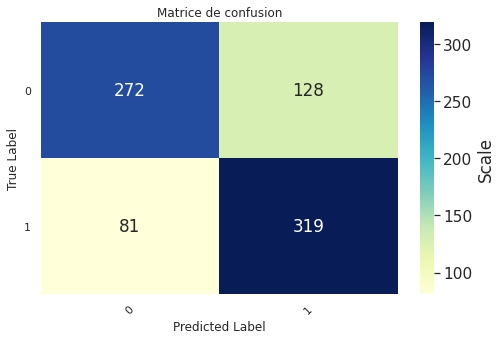

In [ ]:
# selection d'un echantillon
nbsamples=800
df_sample=df_test.sample(n = nbsamples) 

print ("\nPrédiction sur ",nbsamples," données tirées au hasard \n")       
y_test=df_sample.sentiment 
X=df_sample.review
y_pred = clf_loaded.predict(X)

# autres mesures et matrice de confusion
MyshowAllScores(y_test,y_pred)

# Generer des Avis


**LSTM + Embedding**

**Setup**

In [10]:
# librairies gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors # to load gzip bin files with KeyedVectors.load_word2vec_format
from gensim import models
from gensim.models.word2vec import Word2Vec
import numpy as np

from gensim import models
model_stanford = models.KeyedVectors.load_word2vec_format("glove.6B.100d.w2vformat.txt", binary=False)

#https://machinelearningmastery.com/develop-word-based-neural-language-models-python-keras/
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding


# generate a sequence from a language model
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# pre-pad sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
	return in_text

def get_embedding_matrix(embeddings,words,vocabulary_size,dimension):
  # Preparation de la matrice des embeddings embedding matrix
  embedding_matrix = np.zeros((vocabulary_size, dimension)) #(22 x 100)
  for word, i in words.word_index.items():
    try: # lever l'exception si un mot n'est pas trouvé dans les embeddings
        embedding_vector = embeddings.wv[word] 
        embedding_matrix[i] = embedding_vector
    except KeyError: # mot non trouvé dans les embeddings
        # print(word)
        pass
  return embedding_matrix

**Tri des avis positifs**

In [14]:
# source text
df = pd.read_csv("ReviewsLabelled.csv", names=['sentence','sentiment','source'], header=0,sep='\t', encoding='utf8')

object_dataframe = df[df['sentiment'] == 1].sentence
data = ""
for r in object_dataframe:
  data += r # + '\n'

**Entrainement du model**

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0] #codage des mots

vocab_size = len(tokenizer.word_index) + 1 #pourquoi +1 ???
print('Vocabulary Size: %d' % vocab_size)

# encode 2 words -> 1 word
sequences = list()
for i in range(2, len(encoded)):
	sequence = encoded[i-2:i+1]
	sequences.append(sequence)

# pad sequences
max_length = max([len(seq) for seq in sequences]) #taille de la sequence la plus longue ? 3
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre') #padding

# split into input and output elements
sequences = array(sequences) #utile??
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

DIMENSION=100 #max_length#20
embedding_matrix=get_embedding_matrix(model_stanford,tokenizer,vocab_size,DIMENSION)

#---------- model ---------------
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length-1))#, trainable=False)) 
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# print(model.summary())
# model.fit(X, y, epochs=100, verbose=2)
# model.save('model_opinions_embeddings.bin')

Vocabulary Size: 3426


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


**Generation**

In [16]:
from tensorflow import keras

new_model = keras.models.load_model('model_opinions_embeddings.bin')

print(generate_seq(new_model, tokenizer, max_length-1, 'this place', 10))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


this place is a great deal the ambience is wonderful and imaginative


# Experimentations


Principe :
  
  Partie: I

  - Entrainer un classifier --> relever l'accuracy
  - Génerer des avis positifs de taille variables (10, 20 mots)
  - Classer les données générés
  
  Partie II:

  -Ré-entrainer le classifier en changeant une partie des données par les données générés --> relever l'accuracy
  -Générer de nouveaux avis positifs
  - Les classer

**POSITIVE**

In [63]:
#Premier générateur
object_dataframe = df_train[df_train['sentiment'] == 1].sentence
data = ""
for r in object_dataframe:
  data += r # + '\n'

tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0] #codage des mots

vocab_size = len(tokenizer.word_index) + 1

# encode 2 words -> 1 word
sequences = list()
for i in range(2, len(encoded)):
  sequence = encoded[i-2:i+1]
  sequences.append(sequence)

# pad sequences
max_length = max([len(seq) for seq in sequences]) #taille de la sequence la plus longue ? 3
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre') #padding

# split into input and output elements
sequences = array(sequences) #utile??
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

# generator = train_generator(data, 1)
generator = keras.models.load_model('model_opinions_embeddings.bin')

#générer des mots
nb = 100

generated_text = []
for i in range(nb):
  start = np.random.randint(0, len(X)-1) 
  pattern = X[start] 
  txt = ""
  for w in pattern:
    for word, index in tokenizer.word_index.items():
      if index == w:
        txt += word + ' '
  generated_text.append(generate_seq(generator, tokenizer, max_length-1, txt, 10 if i<nb/2 else 20))

print(np.matrix(generated_text))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[["and all  the characters are interesting and you won't be disappointed the"
  "a riot  to see that renowned silent screenwriter frances marion hasn't missed"
  'to do  this to be the hardest decision honestly all of the'
  'our server  was very good and i think the quality is excellent'
  'one bite  i was not as a child on tv back in'
  'of the  film is an excellent job of tying up the subpar'
  "simple drink  menu the salad had just as spacek owned coal miner's"
  'it is  a great deal the ambience is wonderful and imaginative look'
  'of south  africa understand its past and the service was good and'
  'it is  a great deal the ambience is wonderful and imaginative look'
  'really unfolds  gradually and leaves room for this place is a great'
  'a super  ending that depicts a great deal the ambience is wonderful'
  "entrance and  mini dance scene i'm a big winner the food was"
  'they do  a great deal the ambience is wonderful and imaginative look'
  'first say  this is a great deal t

[0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1]
Accuracy : 0.840
Classification Report
              precision    recall  f1-score   support

         0.0    0.00000   0.00000   0.00000         0
         1.0    1.00000   0.84000   0.91304       100

    accuracy                        0.84000       100
   macro avg    0.50000   0.42000   0.45652       100
weighted avg    1.00000   0.84000   0.91304       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


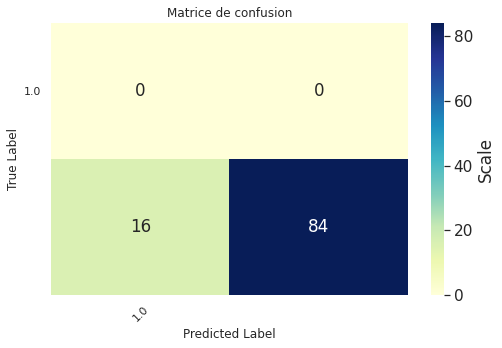

[1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy : 0.920
Classification Report
              precision    recall  f1-score   support

         0.0    0.00000   0.00000   0.00000         0
         1.0    1.00000   0.92000   0.95833       100

    accuracy                        0.92000       100
   macro avg    0.50000   0.46000   0.47917       100
weighted avg    1.00000   0.92000   0.95833       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


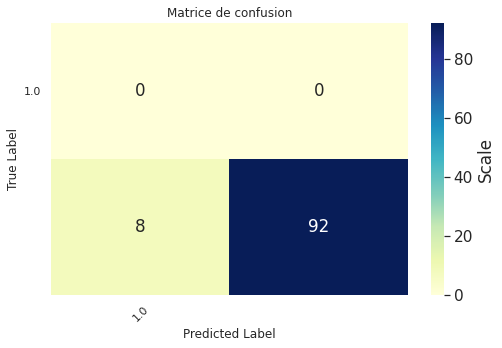

In [80]:
classifier = pickle.load(open('NewSentimentModel.pkl', 'rb'))
y_pred = classifier.predict(generated_text)
print(y_pred)
MyshowAllScores(np.ones(nb),y_pred)

classifier = pickle.load(open('SentimentModel.pkl', 'rb'))
y_pred = classifier.predict(generated_text)
print(y_pred)
MyshowAllScores(np.ones(nb),y_pred)

# scores = []
# for i in range(5):
#   idx = np.random.randint(0, 100, 20);
#   sample = np.array(generated_text)[idx]
#   y_pred = classifier.predict(sample)
#   print(y_pred)
#   MyshowAllScores(np.ones(20),y_pred)
#   scores.append(accuracy_score(np.ones(20), y_pred))

# print(scores)
# print(np.average(scores))
# print(np.nanstd(scores))

**NEGATIVE**

In [66]:
#Premier générateur
object_dataframe = df_train[df_train['sentiment'] == 0].sentence
data = ""
for r in object_dataframe:
  data += r # + '\n'

tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0] #codage des mots

vocab_size = len(tokenizer.word_index) + 1

# encode 2 words -> 1 word
sequences = list()
for i in range(2, len(encoded)):
  sequence = encoded[i-2:i+1]
  sequences.append(sequence)

# pad sequences
max_length = max([len(seq) for seq in sequences]) #taille de la sequence la plus longue ? 3
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre') #padding

# split into input and output elements
sequences = array(sequences) #utile??
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

# generator = train_generator(data, 1)
generator = keras.models.load_model('model_opinions_negative_embeddings.bin')

#générer des mots
nb = 100

generated_negative_text = []
for i in range(nb):
  start = np.random.randint(0, len(X)-1) 
  pattern = X[start] 
  txt = ""
  for w in pattern:
    for word, index in tokenizer.word_index.items():
      if index == w:
        txt += word + ' '
  generated_negative_text.append(generate_seq(generator, tokenizer, max_length-1, txt, 10 if i<nb/2 else 20))

print(np.matrix(generated_negative_text))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[["it at  all costs i know that jim o'connor was very disappointed"
  'only bad  script is a bit of a movie that is screened'
  'the most  annoying and idiotic show i have ever seen he surely'
  'trash this  is a bit of a movie that is screened in'
  "bad choice  the pleather case doesn't fit useless phone simply deaf it"
  'in more  than a subway sub which offers better and more amount'
  'stinker smells  like a loud buzzing to override all your conversations then'
  'oh so  stale the chicken dishes are close to room temp i'
  'mclaglen was  even more stupid is that the ending is like experiencing'
  "a doubt  the worst i have ever seen he surely doesn't know"
  'the food  was mediocre i will not be back here worst food'
  'all the  dialogue is composed of things that make little sense about'
  'not even  a sequel to this place is not a good way'
  'the ambiance  here did not work with my phone got to be'
  'car breaks  down in front of the worst i have ever seen'
  'who in  their rig

[0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1
 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
Accuracy : 0.750
Classification Report
              precision    recall  f1-score   support

         0.0    1.00000   0.75000   0.85714       100
         1.0    0.00000   0.00000   0.00000         0

    accuracy                        0.75000       100
   macro avg    0.50000   0.37500   0.42857       100
weighted avg    1.00000   0.75000   0.85714       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


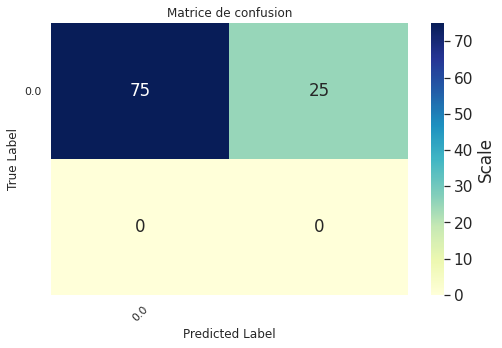

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy : 0.980
Classification Report
              precision    recall  f1-score   support

         0.0    1.00000   0.98000   0.98990       100
         1.0    0.00000   0.00000   0.00000         0

    accuracy                        0.98000       100
   macro avg    0.50000   0.49000   0.49495       100
weighted avg    1.00000   0.98000   0.98990       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


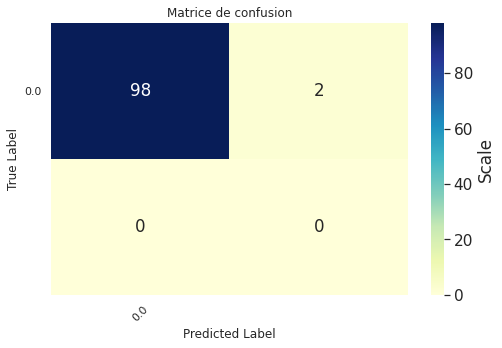

In [81]:
classifier = pickle.load(open('NewSentimentModel.pkl', 'rb'))
y_pred = classifier.predict(generated_negative_text)
# print(y_pred)
# MyshowAllScores(np.zeros(nb),y_pred)

# classifier = pickle.load(open('SentimentModel.pkl', 'rb'))
# y_pred = classifier.predict(generated_negative_text)
# print(y_pred)
# MyshowAllScores(np.zeros(nb),y_pred)

scores = []
for i in range(5):
  idx = np.random.randint(0, 100, 20);
  sample = np.array(generated_negative_text)[idx]
  y_pred = classifier.predict(sample)
  print(y_pred)
  MyshowAllScores(np.zeros(20),y_pred)
  scores.append(accuracy_score(np.zeros(20), y_pred))

print(scores)
print(np.average(scores))
print(np.nanstd(scores))

**Mixte**

[0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0]
Accuracy : 0.700
Classification Report
              precision    recall  f1-score   support

         0.0    0.58333   0.87500   0.70000         8
         1.0    0.87500   0.58333   0.70000        12

    accuracy                        0.70000        20
   macro avg    0.72917   0.72917   0.70000        20
weighted avg    0.75833   0.70000   0.70000        20



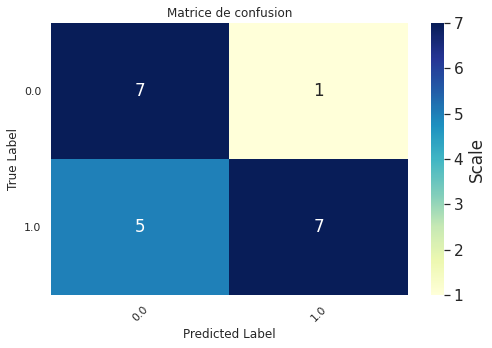

[0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0]
Accuracy : 0.700
Classification Report
              precision    recall  f1-score   support

         0.0    0.58333   0.87500   0.70000         8
         1.0    0.87500   0.58333   0.70000        12

    accuracy                        0.70000        20
   macro avg    0.72917   0.72917   0.70000        20
weighted avg    0.75833   0.70000   0.70000        20



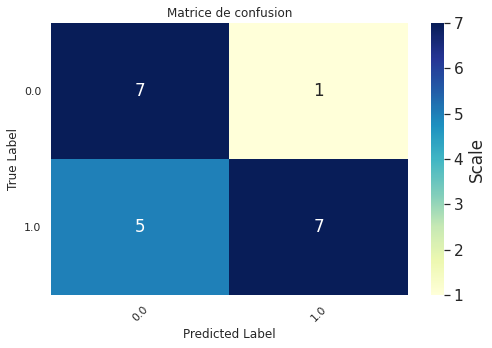

[0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0]
Accuracy : 0.850
Classification Report
              precision    recall  f1-score   support

         0.0    0.88889   0.80000   0.84211        10
         1.0    0.81818   0.90000   0.85714        10

    accuracy                        0.85000        20
   macro avg    0.85354   0.85000   0.84962        20
weighted avg    0.85354   0.85000   0.84962        20



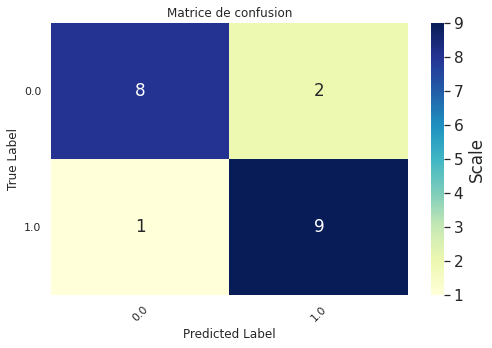

[0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1 0]
Accuracy : 0.750
Classification Report
              precision    recall  f1-score   support

         0.0    0.72727   0.80000   0.76190        10
         1.0    0.77778   0.70000   0.73684        10

    accuracy                        0.75000        20
   macro avg    0.75253   0.75000   0.74937        20
weighted avg    0.75253   0.75000   0.74937        20



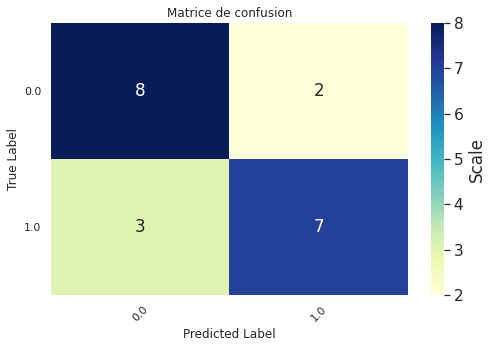

[1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0]
Accuracy : 0.850
Classification Report
              precision    recall  f1-score   support

         0.0    0.70000   1.00000   0.82353         7
         1.0    1.00000   0.76923   0.86957        13

    accuracy                        0.85000        20
   macro avg    0.85000   0.88462   0.84655        20
weighted avg    0.89500   0.85000   0.85345        20



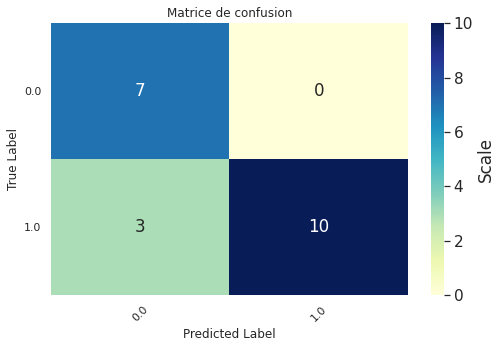

[0.7, 0.7, 0.85, 0.75, 0.85]
0.77
0.06782329983125268


In [85]:
y_true = np.concatenate( (np.ones(int(nb/2)),np.zeros(int(nb/2))), axis=0)

idx = np.random.randint(0, 100, 50);
x_test = np.concatenate( (np.array(generated_text)[idx], np.array(generated_negative_text)[idx] ), axis=0)

classifier = pickle.load(open('NewSentimentModel.pkl', 'rb'))
# y_pred = classifier.predict(x_test)
# print(y_pred)
# MyshowAllScores(y_true,y_pred)

# classifier = pickle.load(open('SentimentModel.pkl', 'rb'))
# y_pred = classifier.predict(x_test)
# print(y_pred)
# MyshowAllScores(y_true,y_pred)

scores = []
for i in range(5):
  idx = np.random.randint(0, 100, 20);
  sample = x_test[idx]
  sample_true = y_true[idx]
  y_pred = classifier.predict(sample)
  print(y_pred)
  MyshowAllScores(sample_true,y_pred)
  scores.append(accuracy_score(sample_true, y_pred))

print(scores)
print(np.average(scores))
print(np.nanstd(scores))